# 01 – Exploration of the Collaboration Network

This notebook performs an initial exploratory analysis of the collaboration network used in the project.

Goals:

1. Load the edge list from `data/collaboration.edgelist.txt`.
2. Inspect the raw structure of the data (first edges, basic sanity checks).
3. Compute basic graph statistics: number of nodes, number of edges, degree distribution.
4. Build a NetworkX graph and compute simple network-level metrics.
5. Plot a histogram of the degree distribution.

This exploratory analysis provides context for the GNN-based link prediction experiments that will be developed in later notebooks.

In [12]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

# Paths
base_dir = Path("..")
data_dir = base_dir / "data"
edge_list_path = data_dir / "collaboration.edgelist.txt"

print("Base dir:", base_dir.resolve())
print("Data dir:", data_dir.resolve())
print("Edge list path:", edge_list_path)

if not edge_list_path.exists():
    raise FileNotFoundError(f"Edge list not found at: {edge_list_path}")

Base dir: /workspaces/upe-ppgec-netsci-2025-1-projeto-icbvo
Data dir: /workspaces/upe-ppgec-netsci-2025-1-projeto-icbvo/data
Edge list path: ../data/collaboration.edgelist.txt


## 1. Load the edge list

The file is expected to be a whitespace-separated text file with two integer columns, representing undirected edges `(u, v)` between authors (nodes).

In [13]:
df_edges = pd.read_csv(edge_list_path, sep=r"\s+", header=None, names=["u", "v"])
print("Raw edge list loaded with shape:", df_edges.shape)
df_edges.head()

Raw edge list loaded with shape: (93439, 2)


,u,v
0,0,1680
1,0,6918
2,0,19642
3,1,4131
4,1,5645


Remove potential self-loops and enforce a canonical ordering for undirected edges (i.e., always `u < v`) and drop duplicates. This makes the edge set easier to reason about and avoids double-counting edges during analysis.

In [14]:
# Remove self-loops
df_edges = df_edges[df_edges["u"] != df_edges["v"]].copy()

# Canonical form for undirected edges
u_min = np.minimum(df_edges["u"].values, df_edges["v"].values)
v_max = np.maximum(df_edges["u"].values, df_edges["v"].values)
df_edges["u"] = u_min
df_edges["v"] = v_max

# Drop duplicates
df_edges = df_edges.drop_duplicates().reset_index(drop=True)

print("After cleaning:")
print("  Number of edges:", len(df_edges))
print("  Min node ID:", df_edges[["u", "v"]].values.min())
print("  Max node ID:", df_edges[["u", "v"]].values.max())

df_edges.head()

After cleaning:
  Number of edges: 93439
  Min node ID: 0
  Max node ID: 23132


,u,v
0,0,1680
1,0,6918
2,0,19642
3,1,4131
4,1,5645


## 2. Basic statistics: number of nodes and edges

We now compute the number of unique nodes and confirm the size of the network stated in the article (23,133 nodes and 93,439 undirected edges).

In [15]:
nodes = pd.unique(pd.concat([df_edges["u"], df_edges["v"]], axis=0))
num_nodes = len(nodes)
num_edges = len(df_edges)

print(f"Number of nodes: {num_nodes}")
print(f"Number of undirected edges: {num_edges}")

Number of nodes: 23133
Number of undirected edges: 93439


## 3. Build a NetworkX graph

We construct an undirected NetworkX graph from the cleaned edge list. This will allow us to compute various network-level metrics and explore structural properties such as degree distribution, clustering, and connectivity.

In [16]:
G = nx.Graph()
G.add_edges_from(df_edges[["u", "v"]].itertuples(index=False, name=None))

print(G)
print("Number of nodes (G):", G.number_of_nodes())
print("Number of edges (G):", G.number_of_edges())

Graph with 23133 nodes and 93439 edges
Number of nodes (G): 23133
Number of edges (G): 93439


## 4. Degree distribution

We examine the degree distribution, which is a key characteristic of collaboration networks. Many real-world collaboration networks are known to be heavy-tailed, with a small number of highly connected authors and a large number of authors with few collaborators.

In [17]:
# Compute degrees for all nodes
degrees = dict(G.degree())
deg_values = np.array(list(degrees.values()))

deg_series = pd.Series(deg_values, name="degree")
deg_series.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

count    23133.000000
mean         8.078416
std         10.627266
min          1.000000
25%          3.000000
50%          5.000000
75%          9.000000
90%         18.000000
99%         50.000000
max        279.000000
Name: degree, dtype: float64

Plot a histogram of the degree distribution (in linear scale) and then in log-log scale to better visualize the tail behavior of highly connected nodes.

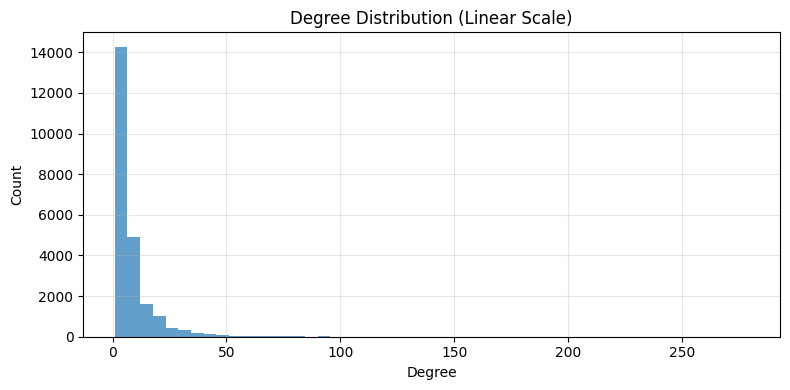

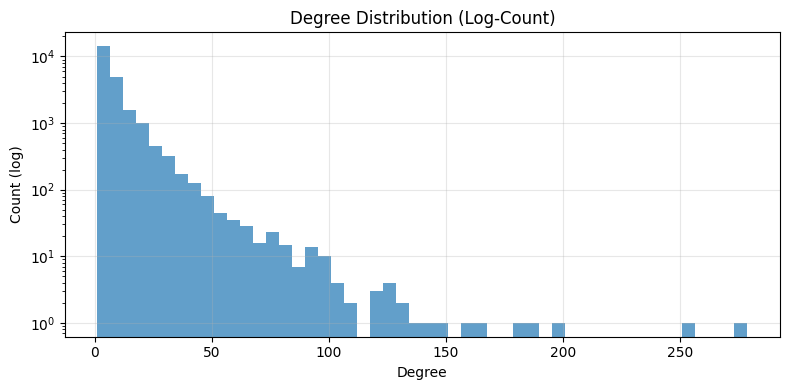

In [18]:
plt.figure(figsize=(8, 4))
plt.hist(deg_values, bins=50, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution (Linear Scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(deg_values, bins=50, alpha=0.7, log=True)
plt.xlabel("Degree")
plt.ylabel("Count (log)")
plt.title("Degree Distribution (Log-Count)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Connected components and giant component

Collaboration networks often contain a **giant connected component** that includes the vast majority of authors, plus a set of much smaller components. We examine the component size distribution and extract the largest one for further analysis in subsequent notebooks if needed.

In [19]:
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]

component_sizes_sorted = sorted(component_sizes, reverse=True)

print("Number of connected components:", len(components))
print("Size of largest component:", component_sizes_sorted[0])
print("Size of 2nd largest component:", component_sizes_sorted[1] if len(component_sizes_sorted) > 1 else "-")

pd.Series(component_sizes_sorted[:10], name="component_size").to_frame().style.bar()

Number of connected components: 567
Size of largest component: 21363
Size of 2nd largest component: 21


,component_size
0,21363
1,21
2,17
3,15
4,15
5,13
6,10
7,10
8,9
9,9


Optionally, we can extract the giant component and compute some basic metrics such as average clustering and approximate characteristic path length.

> **Note:** Computing shortest-path-based metrics on the whole graph may be expensive. Here we restrict to the largest connected component.

In [20]:
# Extract largest connected component
giant_nodes = max(components, key=len)
G_giant = G.subgraph(giant_nodes).copy()

print("Giant component:")
print("  Nodes:", G_giant.number_of_nodes())
print("  Edges:", G_giant.number_of_edges())

# Average clustering coefficient
avg_clustering = nx.average_clustering(G_giant)
print("Average clustering (giant component):", avg_clustering)

# Approximate characteristic path length: we can sample a subset of nodes
    
sample_size = 1000
sample_nodes = np.random.choice(list(G_giant.nodes()), size=min(sample_size, G_giant.number_of_nodes()), replace=False)

lengths = []
for i, u in enumerate(sample_nodes):
    sp_lengths = nx.single_source_shortest_path_length(G_giant, u)
    # Exclude distance 0 to itself
    vals = [d for v, d in sp_lengths.items() if v != u]
    if vals:
        lengths.append(np.mean(vals))

approx_char_path_length = float(np.mean(lengths)) if lengths else float("nan")
print("Approximate average shortest-path length (sampled):", approx_char_path_length)

Giant component:
  Nodes: 21363
  Edges: 91286
Average clustering (giant component): 0.6417316374785165
Approximate average shortest-path length (sampled): 5.308654245857129


## 6. Summary

In this notebook we:

- Loaded the collaboration network from a simple edge list file.
- Cleaned the data by removing self-loops and duplicate edges.
- Confirmed the overall network size (number of nodes and edges).
- Constructed a NetworkX graph and computed the degree distribution.
- Investigated the connected components and characterized the giant component.
- Computed basic structural metrics such as average clustering and an approximate characteristic path length.

These exploratory findings provide context for the GNN-based link prediction experiments and justify the use of graph neural networks on this large, highly structured collaboration network.

In [21]:
print('Notebook 01 finished successfully. 🚀')

Notebook 01 finished successfully. 🚀
